# Tutorial 8: Convolutional neural networks with Keras


Welcome to the eighth tutorial of the course 'Machine learning for Precision Medicine'.

In this exercise we will work with the colorectral histology MNIST dataset from [kaggle](https://www.kaggle.com/kmader/colorectal-histology-mnist). This data set represents a collection of 4500 textures in histological images (28x28x3) of human colorectal cancer and comprises 8 different tissue classes. 

1) Tumor  
2) Stroma  
3) Complex  
4) Lympho  
5) Debris  
6) Mucosa  
7) Adipose  
8) Empty  

Last week, you learned how to use tensorflow to create your classification model. This week we will use Keras, which is built on top of tensorflow and makes our lives a lot easier. 

**Note:**  
We created this notebook on MacOS with `keras 2.1.6`, `tensorflow 1.6.0` and `python 3.5.5`. You should be able to use newer versions. However the **MacOS anaconda release of tensorflow with python 3.7 is broken** and you will not be able to use `Dropout` or some other layers. You won't need those layers for the main part of the exercise, but you might want to use them for the competition. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, GlobalMaxPool2D, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
print(f"tensorflow:\t{tf.__version__}")
print(f"keras:\t\t{keras.__version__}")

tensorflow:	1.13.1
keras:		2.2.4-tf


## Preprocessing  the data

We did this already a bit for you. Basically kaggle provides a table that has all 28x28 pixels in columns and a label column from 1-8. We have applied one-hot-encoding to the labels, i.e. 1: [1,0,0,0,0,0,0,0] 2: [0,1,0,0,0,0,0,0] and stacked all flattened image vectors on top of each other. This time we will split the data into training, test and validation set. We are providing you the X_train, Y_train, and X_test arrays. Now we split X_train and Y_train again into training and validation sets. 

In [2]:
X = np.load('X_train.npy')
Y = np.load('Y_train.npy')
print('X.shape = {}'.format(X.shape))
print('Y.shape = {}'.format(Y.shape))

X.shape = (4500, 2352)
Y.shape = (4500, 8)


In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.15, random_state=1)

## Introduction to Keras

Keras greatly simplifies the task of building and training deep neural networks. In this exercise you will learn how to build a feed forward and a convolutional neural network using the keras Sequential API. You will then be free to explore regularization and other ways to improve your model.

Once you're satisfied with your performance, you can enter our competition and compete against the other teams. The best teams will be announced one week after the hand-in date.

### Layers

In Keras the main building blocks you will need to build a model are [Keras layers](https://keras.io/layers/about-keras-layers/). Layers implement many of the most common operations performed in neural networks. The beauty of Keras is that you only have to define the shape of your input and the architecture (layer hyper-parameters and activation functions), and the correct shapes for all of the weight matrices and the output etc. will automatically be inferred.

In this exercise we will look specifically at `Dense`, `Conv2D`, `MaxPooling`. We will also introduce the utility layer `Flatten` and the regularization layer `Dropout`.

### The Sequential API

As mentioned above, we build [Keras models](https://keras.io/models/about-keras-models/) using layers. There are two ways to do this. If every layer of your network simply takes the output of the previous layer  and feeds into the next layer you can build your model using the [Sequential API](https://keras.io/models/sequential/). However, more complex architectures with different connectivity patterns require the use of the [Functional API](https://keras.io/models/model/).

For example, to build a softmax regression classifier with l2-regularization, we could do the following: (Ignore the warning)


In [4]:
ridgemodel = keras.Sequential()
ridgemodel.add(Dense(8, activation='softmax', input_shape=(X.shape[1],),
                     kernel_regularizer=regularizers.l2(0.001))) # 2352 input features, 8 output features

Instructions for updating:
Colocations handled automatically by placer.


Before you can train the model, it has to be compiled with an optimizer that will adjust the weights after each round:

In [5]:
ridgemodel.compile(Adam(0.0005), 'categorical_crossentropy', metrics=['accuracy'])

You can print the architecture with the `summary()` method:

In [6]:
ridgemodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 18824     
Total params: 18,824
Trainable params: 18,824
Non-trainable params: 0
_________________________________________________________________


Layers can have trainable weights, which we can access with the `get_weights()` method:

In [7]:
# we print the shape of the weight matrix and bias vector:
for w in ridgemodel.layers[-1].get_weights():
    print(w.shape)

(2352, 8)
(8,)


Keras models are trained with the gradient descent algorithm, for which there are different optimizers available. We can train this model iteratively with minibatch gradient descent. Keras also takes care of this for us:

Now we fit our model, by passing the training data in batches, and train for 100 epochs. 

In [8]:
history = ridgemodel.fit(X_train, y_train, batch_size=128,
                         epochs=100, shuffle=True,
                         validation_data=(X_valid, y_valid),verbose=False)

Instructions for updating:
Use tf.cast instead.


And we write a function to look at our training results

In [9]:
def plothistory(h, metric='acc'):
    
    
    if metric == 'acc':
        plt.title('accuracy')
    else:
        plt.title(metric)
        
    plt.plot(h.history['val_'+metric], label='validation')
    plt.plot(h.history[metric], label='train')
    plt.legend(loc='lower right')
    plt.xlabel('epoch')


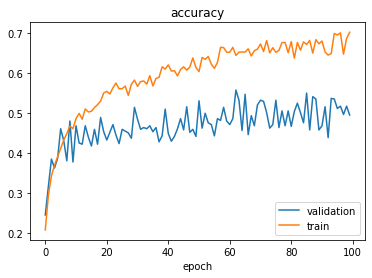

In [10]:
plothistory(history)

In [11]:
print('Baseline Performance: {}'.format(np.mean(history.history['val_acc'][-4:])))

Baseline Performance: 0.5062962770462036


Generally when working with neural networks it is good practice to establish a baseline performance estimate using a simple method, as we did above with only a softmax regression model. The classifier should have gotten an accuracy of about ~0.52 on the validation set. We will now try to beat this performance with neural networks. 

## Fully Connected Network

Let's implement a fully connected network using the Keras sequential API. In a fully connected network each neuron of a given layer is connected to each neuron in the following layer. A layer that contains a number of neurons which all recieve the same input is called a dense layer, because the neurons are "densely connected". Here we stack several of these layers on top of each other. 

# Task 1: Implement a FCNN 
Create a fully connected model by using the keras functions introduced in the example above. Try using different numbers of layers, i.e. start with 3 Dense layers and try different numbers of nodes (neurons). Think about the activation functions that you will need to use for hidden and output layers. 

Hint: Sequential(), add(Dense()), ...

In [12]:
#STUDENT

def get_fully_connected(input_shape=(2352,), n_classes=8):
    
    model = keras.Sequential()
    model.add(Dense(50, activation='relu', input_shape=input_shape))
    #model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(8, activation='softmax'))
    
    return model

In [13]:
fcnet = get_fully_connected()
fcnet.summary() #Look at the model architechture and the number of trainable parameters. 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                117650    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 408       
Total params: 125,708
Trainable params: 125,708
Non-trainable params: 0
_________________________________________________________________


Below is the architecture we chose when writing the exercise. Try re-implementing this architecture if your model is not learning. We used ReLU activation functions for every layer except the output layer.

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_2 (Dense)              (None, 50)                117650    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 408       
=================================================================
Total params: 125,708
Trainable params: 125,708
Non-trainable params: 0
_________________________________________________________________
```

Now we compile the model using the Adam optimizer with a learning rate of 0.0005. Since we have a multi-class model, we need to use a 'categorical-crossentropy' loss function.

In [14]:
fcnet.compile(Adam(lr=0.0005), 'categorical_crossentropy', metrics=['accuracy'])

Let's get the training started...

In [15]:
history = fcnet.fit(X_train, y_train, batch_size=128, epochs=50, shuffle=True,
                    validation_data=(X_valid, y_valid), verbose=0)

FCNN Performance: 0.6348148584365845


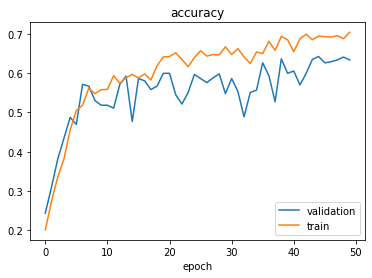

In [16]:
plothistory(history)
print('FCNN Performance: {}'.format(np.mean(history.history['val_acc'][-4:])))

The fully connected network you implemented above should have gotten slighly better performance on the validation set. However, both the baseline model and the fully connected model treat every single color channel of every single input pixel as an independent feature. This doesn't truly reflect the problem we are trying to solve. Convolutional Neural Networks can make use of the local dependencies between pixels and are able learn hierarchical feature representations, which might help improve performance on this dataset. 

## Convolutional Neural Networks

Whereas a fully-connected layer requires a flattened image vector, a convolutional neural network an input shape of (pixels_rows, pixel_columns, color-channel). In our case for one image (28,28,3). 

To do so, we can just reshape the stacked image arrays back to the image dimensions by using np.reshape():


In [17]:
X_train_rs, X_valid_rs = np.reshape(X_train, (-1, 28, 28, 3)),  np.reshape(X_valid, (-1, 28, 28, 3))
X_train_rs.shape

(3825, 28, 28, 3)

** Expected output:** 
(3825, 28, 28, 3)

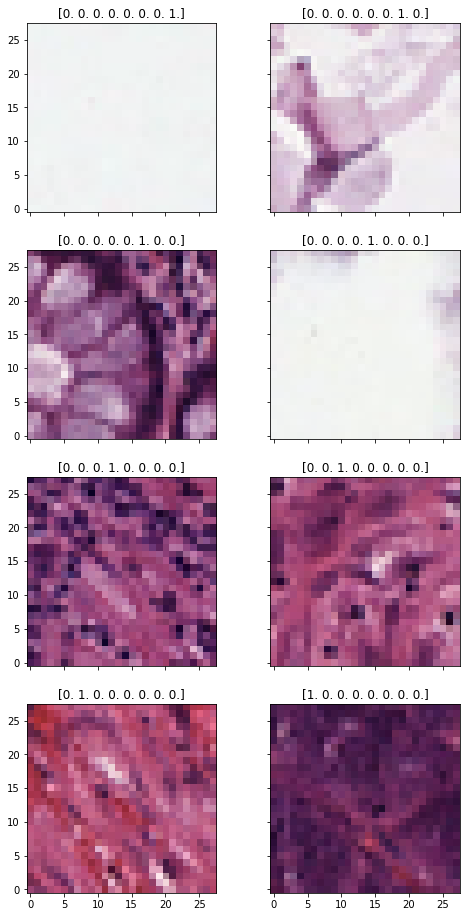

In [18]:
# plot an example of each class
fig, ax = plt.subplots(4,2, figsize=(8,16), sharex=True, sharey=True)
for i, j in enumerate([6, 1, 3, 28, 23, 4, 5, 0]):
    r = i // 2
    c = i % 2
    ax[r,c].imshow(X_train_rs[j], origin='lower')
    ax[r,c].title.set_text(str(y_train[j]))

# Task 2: Implement a CNN

Now we can create a CNN with keras. Convolutional layers, which are often combined with max-pooling operations, can function as powerful feature-extractors. As we go deeper in the network the learned features become more complex.

1) For the implementation, you start again with initializing the Sequential model. Then, you add a convolutional layer, in which you apply a number of filters/kernels (i.e. 32) of i.e. size 3x3 over the input representation with an activation function. The output are the convolved features. 

2) After each Conv layer, we apply MaxPooling to downsample the feature representation again, keeping "dominant features". For each of the regions traversed by the max-pooling filter, we will take the maximum activation of that region for each channel and create a new output tensor with reduced dimensions where each channel is the maximum activatuon of a that channel the region of the input. 

You can repeat and stack these two layers on top of each other as often as you like, or stack multiple convolutional layers without max-pooling operations between them. For predicting the output, the tissue classes, we need to flatten the features (`Flatten`-layer) and add one or more Dense layers on top. 

Now implement a convolutional neural network model. Try different numbers of layers, different number of filters, 1 or two Dense layers before the output etc.. Remember that your last layer always needs to have the shape `(n_classes, )` and use the softmax activation function.


In [19]:
# STUDENT

def get_cnn(input_shape=(28,28,3), n_classes=8):
        
    model = Sequential()    
    model.add(Conv2D(32,3,input_shape=input_shape))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(64,2,input_shape=input_shape))
    model.add(MaxPooling2D(2))
    model.add(Conv2D(64,2,input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(16, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation ="softmax"))
    
    return model

In [20]:
cnn = get_cnn()
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          16448     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                25616     
__________

Below is the architecture we chose when writing the exercise. Try re-implementing this architecture if your model is not learning. **Tip:** the number of channels in the output of a convolutional layer equals the number of convolutional filters (=kernels) used in that layer. We used ReLU activation functions for every layer except the output layer. We used 3 by 3 convolutional kernels for the first layer, and 2 by 2 convolutional kernels for the other convolutional layers. We added an additional Dense layer with 16 neurons before the output layer and used "valid" padding for all convolutional layers.

```
_______________________________________________________________________________
Layer (type)                           Output Shape               Param #      
===============================================================================
conv2d_1 (Conv2D)                      (None, 26, 26, 32)         896          
_______________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)         (None, 13, 13, 32)         0            
_______________________________________________________________________________
conv2d_2 (Conv2D)                      (None, 12, 12, 64)         8256         
_______________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)         (None, 6, 6, 64)           0            
_______________________________________________________________________________
conv2d_3 (Conv2D)                      (None, 5, 5, 64)           16448        
_______________________________________________________________________________
flatten_1 (Flatten)                    (None, 1600)               0            
_______________________________________________________________________________
dense_7 (Dense)                        (None, 16)                 25616        
_______________________________________________________________________________
dense_8 (Dense)                        (None, 8)                  136          
===============================================================================
Total params: 51,352
Trainable params: 51,352
Non-trainable params: 0
_______________________________________________________________________________
```

In [21]:
import time

start = time.time()
cnn.compile(optimizer=Adam(lr=0.0005), loss=categorical_crossentropy, metrics=['accuracy'])
history = cnn.fit(X_train_rs, y_train, epochs=50, batch_size=128,
                  validation_data=(X_valid_rs, y_valid), shuffle=True
                 ,verbose=False)
end = time.time()
print(end - start)
    
# this can take long to run ( ~2 minutes on a MacBook pro with an i7 and our proposed architecture above)
# ~12 seconds on gtx1060
# ~1 minute on cpu
# ~8 seconds on 4xTesla V100

11.984325170516968


CNN Performance: 0.7456


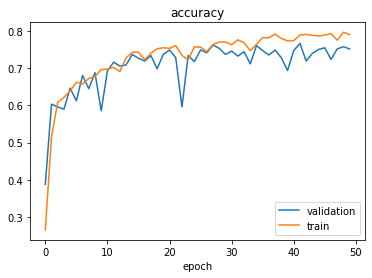

In [22]:
plothistory(history)
print('CNN Performance: {:.4f}'.format(np.mean(history.history['val_acc'][-4:])))

## A Note on Regularization
If you re-implemented our proposed architecture above, you should have gotten a good performance of ~0.75 - 0.8 on the validation set, depending on how many epochs you trained. Did your model get the same? You can now try to improve the performance by for example adding more convolutional filters to the existing layers or by adding additional layers to the network. When you do this, you will likely encounter over-fitting at some point. To prevent over-fitting you can use regularization. Keras offers multiple ways to do regularization. For example when you instantiate a layer, you can set [l1 and l2 regularization penalties](https://keras.io/regularizers/) by using the `kernel_regularizer`, `bias_regularizer` or `activity_regularizer` arguments. Alternatively, you can use dropout regularization. For this you can use the [`Dropout` layer](https://keras.io/layers/core/#dropout).

# Task 3 - Competition!

Get creative! You have a lot of different layers and hyper-parameters to work with. Can you find a model that outperforms the one we proposed above?

A few notes on the competition:

- Write your code in this notebook
- You have to use Keras
- You are only allowed to use the data we provided (`X_train.npy`, `y_train.npy`)
- Averaging the predictions from multiple separate models (ensemble learning) is not allowed
- You have to submit a solution, even if it's just using the model we proposed above
- The evaluation metric is accuracy

In [23]:
# STUDENT
from tensorflow.keras.layers import BatchNormalization
def get_cnn4Comp(input_shape=(28,28,3), n_classes=8):
    model = Sequential()    
    
    model.add(Conv2D(32,3,input_shape=input_shape
                     #, kernel_regularizer=regularizers.l2(0.001)
                    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    
    model.add(Conv2D(64,2,input_shape=input_shape
                     #, kernel_regularizer=regularizers.l2(0.001)
                    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    
    model.add(Conv2D(64,2,input_shape=input_shape
                    # , kernel_regularizer=regularizers.l2(0.001)
                    ))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    
    model.add(Dense(128, activation = "relu", activity_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = "relu", activity_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = "relu", activity_regularizer=regularizers.l2(0.001)))
    model.add(Dense(n_classes, activation ="softmax"))
    
    return model

In [24]:

def get_cnn4Comp(input_shape=(28,28,3), n_classes=8):
    # dropout: https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
    # Conv2D, MaxPooling2D, Dense, Flatten, GlobalMaxPool2D, Dropout
    model = keras.Sequential()
    
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape
                    , kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(rate=0.4))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(64, kernel_size=2, activation='relu'
                    # , kernel_regularizer=regularizers.l2(0.001)
                    ))
    model.add(MaxPooling2D())
    #model.add(GlobalMaxPool2D())
    
    model.add(Conv2D(64, kernel_size=2, activation='relu'
                    # ,kernel_regularizer=regularizers.l2(0.001)
                    ))
    model.add(Dropout(rate=0.3))
    #model.add(MaxPooling2D())
    
    model.add(Conv2D(64, kernel_size=2, activation='relu'
                    # ,kernel_regularizer=regularizers.l2(0.001)
                    ))
    model.add(Dropout(rate=0.4))
    #model.add(MaxPooling2D())
    # flatten better than globalmaxpool
    
    model.add(Flatten())
    #model.add(GlobalMaxPool2D())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation = "relu", activity_regularizer=regularizers.l2(0.000001)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', activity_regularizer=regularizers.l2(0.000001)))
    model.add(Dropout(rate=0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

Once you have trained your final model, please adapt the code-snippets below to create your submission. If you submit any other format than `.npy` and the shape of the array is different than (500, 8), we will not process your submission. **Please also call model.summmary() and paste the text into the text field of your submission!**. As always also submit the notebook itself.

In [25]:
#comp_model = get_cnn4Comp()
comp_model = load_model("82percent.h5")
# Call model.summary() and paste the text into your submission on moodle:
comp_model.summary(line_length=140)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
____________________________________________________________________________________________________________________________________________
Layer (type)                                                   Output Shape                                            Param #              
conv2d_24 (Conv2D)                                             (None, 26, 26, 32)                                      896                  
____________________________________________________________________________________________________________________________________________
dropout_20 (Dropout)                                           (None, 26, 26, 32)                                      0                    
____________________________________________________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D)        

In [26]:
start = time.time()
from tensorflow.keras.optimizers import SGD
#comp_model.compile(optimizer=Adam(lr=0.0001), loss=categorical_crossentropy, metrics=['accuracy'])
#history_comp = comp_model.fit(X_train_rs, y_train,
#                  epochs=200, batch_size=256,
#                  validation_data=(X_valid_rs, y_valid), shuffle=True
#                 ,verbose=1)
end = time.time()
print(end - start)
#plothistory(history_comp)

6.604194641113281e-05


In [27]:
#print('CNN Performance: {:.4f}'.format(np.mean(history_comp.history['val_acc'][-4:])))
#plothistory(history_comp)

In [28]:
# Adapt this code to create the data for your submission
X_competition = np.load('X_test.npy')
X_competition = X_competition.reshape(-1,28,28,3) # reshape the data as we did above, assuming you are using a CNN, most importantly: KEEP THE SAME ORDER Of OBSERVATIONS!

predictions = comp_model.predict(X_competition) # do this after fitting your model of course
np.save('predictions.npy', predictions)